# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral Cloning


In [1]:
# import packages

import csv
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Cropping2D, ELU
from keras.callbacks import EarlyStopping

# set params
offset_angle = 0.20
test_sample_fraction = 0.20
im_shape = (160,320,3)
nvidia_crop = ((54,40),(60,60))

cameras = { 'center':{'index':0, 'offset':0},
            'left':{'index':1, 'offset': + offset_angle},
            'right':{'index':2, 'offset': - offset_angle} }

# data location
im_folder = "./data/IMG/"
csv_file = "./data/driving_log.csv"

Using TensorFlow backend.


In [2]:
# read driving log frame-by-frame

samples_raw = []
with open(csv_file,'r') as f:
    datareader = csv.reader(f)
    for line in datareader:
        samples_raw.append(line)
        
train_samples, valid_samples = train_test_split(samples_raw, test_size=test_sample_fraction)
print("Train samples: {0}; validation samples: {1}".format(len(train_samples),len(valid_samples)))

Train samples: 5952; validation samples: 1488


Cropped image size: (66, 200, 3)


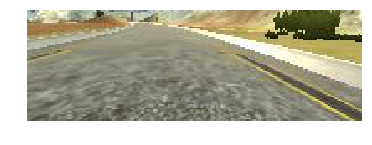

In [3]:
# check image crop region is correct

%matplotlib inline

im_file = train_samples[0][0].split('/')[-1]
im = cv2.imread(im_folder + im_file)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

crop_bottom = im_shape[0] - nvidia_crop[0][1]
crop_top = nvidia_crop[0][0]
crop_left = nvidia_crop[1][0]
crop_right = im_shape[1] - nvidia_crop[1][1]
im_cropped = im[crop_top:crop_bottom,crop_left:crop_right]
print("Cropped image size: {0}".format(im_cropped.shape))
plt.imshow(im_cropped)
plt.axis('off')
plt.show()

In [4]:
# define generator for training data
# include left/right cameras
# include augmentation (horiztonal flipping)
# include small-angle steering supression
# include brightness randomization

def generator_train(samples, batch_size=128):
    # generator for batches of training images
    
    while True:
        steering_angles = []
        images = []
        
        while len(images) < batch_size:
            
            # pick random sample and get steering angle
            sample = random.choice(samples)    
            steering_angle = float(sample[3]) 
            
            # choose which camera
            cam = cameras[random.choice(list(cameras))]
            steering_angle += cam['offset']
            
            # choose possible inversion/flip for data augmentation
            invert = random.choice([True,False])
            if invert:
                steering_angle = - steering_angle
            steering_angles.append(steering_angle)
        
            # get image
            im_file = sample[cam['index']].split('/')[-1]
            im = cv2.imread(im_folder + im_file)       
            im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
            if invert:
                im = cv2.flip(im,+1) 
            images.append(im)

        yield shuffle(np.array(images),np.array(steering_angles))

train_generator = generator_train(train_samples)

In [5]:
# define generator for validation data
# include left/right cameras

def generator_valid(samples, batch_size=128):
    # generator for batches of validation images
    
    while True:
        steering_angles = []
        images = []
        
        while len(images) < batch_size:
            
            # pick random sample and get steering angle
            sample = random.choice(samples)    
            steering_angle = float(sample[3])
            
            # choose which camera
            cam = cameras[random.choice(list(cameras))]
            steering_angle += cam['offset']
            steering_angles.append(steering_angle)
        
            # get image
            im_file = sample[cam['index']].split('/')[-1]
            im = cv2.imread(im_folder + im_file)
            im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
            images.append(im)
                
        yield shuffle(np.array(images),np.array(steering_angles))
        
valid_generator = generator_valid(valid_samples)

In [6]:
# build model - Nvidia

def model_nvidia():
    
    model = Sequential()
    model.add(Cropping2D(nvidia_crop,input_shape=im_shape))
    model.add(Lambda(lambda x: x/255 - 0.5))

    # convolutional layers 
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='elu'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(64,3,3,activation='elu'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(64,3,3,activation='elu'))
    model.add(Dropout(0.25))

    # fully connected
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

    return model
    
# compile model
model = model_nvidia()
model.compile(loss='mse',optimizer='adam')

In [7]:
# fit model
# annoying but unharmful bug in fit_generator is documented here: 
# https://stackoverflow.com/questions/41789961/keras-warning-epoch-comprised-more-than-samples-per-epoch-samples

early_stop = EarlyStopping(min_delta = 0.00001, patience = 32)

history_object = model.fit_generator(train_generator,
                                    samples_per_epoch=len(train_samples),
                                    validation_data=valid_generator,
                                    nb_val_samples=len(valid_samples),
                                    callbacks = [early_stop],
                                    nb_epoch=256)

# save model
model.save('model.h5')


Epoch 1/256
5888/5952 [============================>.] - ETA: 0s - loss: 0.0320

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6016/5952 [==============================] - 12s - loss: 0.0317 - val_loss: 0.0203
Epoch 2/256
6016/5952 [==============================] - 10s - loss: 0.0173 - val_loss: 0.0159
Epoch 3/256
6016/5952 [==============================] - 10s - loss: 0.0153 - val_loss: 0.0148
Epoch 4/256
6016/5952 [==============================] - 10s - loss: 0.0147 - val_loss: 0.0132
Epoch 5/256
6016/5952 [==============================] - 10s - loss: 0.0149 - val_loss: 0.0156
Epoch 6/256
6016/5952 [==============================] - 10s - loss: 0.0140 - val_loss: 0.0140
Epoch 7/256
6016/5952 [==============================] - 10s - loss: 0.0146 - val_loss: 0.0131
Epoch 8/256
6016/5952 [==============================] - 10s - loss: 0.0136 - val_loss: 0.0147
Epoch 9/256
6016/5952 [==============================] - 10s - loss: 0.0136 - val_loss: 0.0141
Epoch 10/256
6016/5952 [==============================] - 10s - loss: 0.0136 - val_loss: 0.0132
Epoch 11/256
6016/5952 [==============================] - 10s

6016/5952 [==============================] - 10s - loss: 0.0086 - val_loss: 0.0084
Epoch 87/256
6016/5952 [==============================] - 10s - loss: 0.0085 - val_loss: 0.0084
Epoch 88/256
6016/5952 [==============================] - 10s - loss: 0.0087 - val_loss: 0.0081
Epoch 89/256
6016/5952 [==============================] - 10s - loss: 0.0083 - val_loss: 0.0081
Epoch 90/256
6016/5952 [==============================] - 10s - loss: 0.0081 - val_loss: 0.0080
Epoch 91/256
6016/5952 [==============================] - 10s - loss: 0.0087 - val_loss: 0.0077
Epoch 92/256
6016/5952 [==============================] - 10s - loss: 0.0080 - val_loss: 0.0074
Epoch 93/256
6016/5952 [==============================] - 10s - loss: 0.0080 - val_loss: 0.0080
Epoch 94/256
6016/5952 [==============================] - 10s - loss: 0.0085 - val_loss: 0.0084
Epoch 95/256
6016/5952 [==============================] - 10s - loss: 0.0081 - val_loss: 0.0076
Epoch 96/256
6016/5952 [=============================

6016/5952 [==============================] - 10s - loss: 0.0059 - val_loss: 0.0052
Epoch 171/256
6016/5952 [==============================] - 10s - loss: 0.0058 - val_loss: 0.0050
Epoch 172/256
6016/5952 [==============================] - 10s - loss: 0.0058 - val_loss: 0.0062
Epoch 173/256
6016/5952 [==============================] - 10s - loss: 0.0058 - val_loss: 0.0051
Epoch 174/256
6016/5952 [==============================] - 10s - loss: 0.0057 - val_loss: 0.0053
Epoch 175/256
6016/5952 [==============================] - 10s - loss: 0.0059 - val_loss: 0.0047
Epoch 176/256
6016/5952 [==============================] - 10s - loss: 0.0058 - val_loss: 0.0048
Epoch 177/256
6016/5952 [==============================] - 10s - loss: 0.0058 - val_loss: 0.0054
Epoch 178/256
6016/5952 [==============================] - 10s - loss: 0.0055 - val_loss: 0.0053
Epoch 179/256
6016/5952 [==============================] - 10s - loss: 0.0057 - val_loss: 0.0050
Epoch 180/256
6016/5952 [===================

6016/5952 [==============================] - 10s - loss: 0.0044 - val_loss: 0.0042
Epoch 255/256
6016/5952 [==============================] - 10s - loss: 0.0044 - val_loss: 0.0043
Epoch 256/256
6016/5952 [==============================] - 10s - loss: 0.0046 - val_loss: 0.0041


In [8]:
# save model
model.save('model.h5')

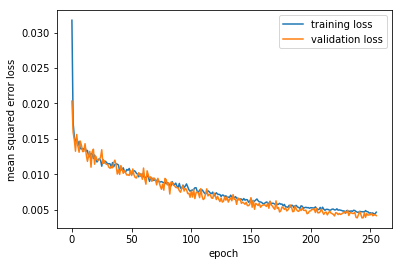

In [9]:
# plot training loss history

%matplotlib inline

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training loss','validation loss'],loc='upper right')
plt.show()